In [51]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from prophet import Prophet

In [28]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [29]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [23]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

,date,total_sales
0,2023-03-01,8645
1,2023-03-02,8560
2,2023-03-03,8690
3,2023-03-04,4365
4,2023-03-05,4565


In [30]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_total_sales_features = create_sales_features(daily_total_sales.copy())


# Drop rows with NaN values created by lag features
daily_total_sales_features.dropna(inplace=True)

display(daily_total_sales_features.head())

,date,total_sales,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,7200,2,1,3,74,2023,7290.0,8645.0,6460.000000
15,2023-03-16,7315,3,1,3,75,2023,7140.0,8560.0,6447.142857
16,2023-03-17,7510,4,1,3,76,2023,7120.0,8690.0,6472.142857
17,2023-03-18,5250,5,1,3,77,2023,5735.0,4365.0,6527.857143
18,2023-03-19,4765,6,1,3,78,2023,3635.0,4565.0,6458.571429


In [31]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [35]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'

In [36]:
X = daily_total_sales_features[FEATURES]
y = daily_total_sales_features[TARGET]

In [37]:
# Determine the split date
split_date = '2025-03-01'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [38]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [41]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [42]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [44]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [48]:
prophet_train = train_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})
prophet_test = test_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})


In [52]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxe2am2kc/bqhjixvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxe2am2kc/hknfnj7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77836', 'data', 'file=/tmp/tmpxe2am2kc/bqhjixvg.json', 'init=/tmp/tmpxe2am2kc/hknfnj7g.json', 'output', 'file=/tmp/tmpxe2am2kc/prophet_model4gadvpha/prophet_model-20250921163946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
future = model.make_future_dataframe(periods=2)

forecast = model.predict(future)

In [54]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds         yhat   yhat_lower    yhat_upper
714 2025-02-26  7877.787473  5225.762279  10289.441580
715 2025-02-27  7901.561628  5513.069674  10276.869963
716 2025-02-28  7588.398857  5217.474965   9821.700517
717 2025-03-01  4709.481363  2273.495811   7129.968229
718 2025-03-02  4865.440511  2319.607327   7397.847194


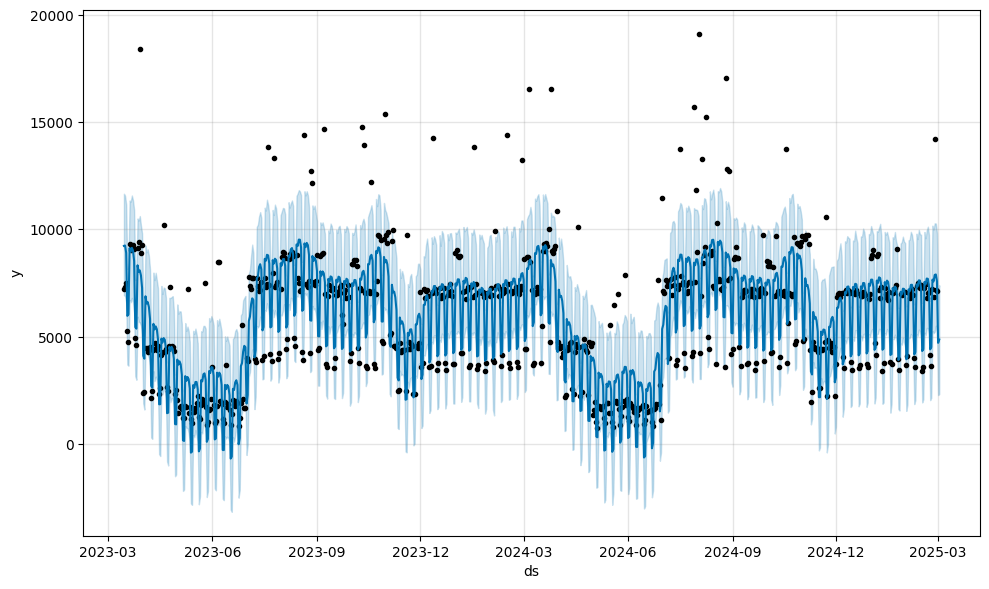

In [55]:
fig1 = model.plot(forecast)

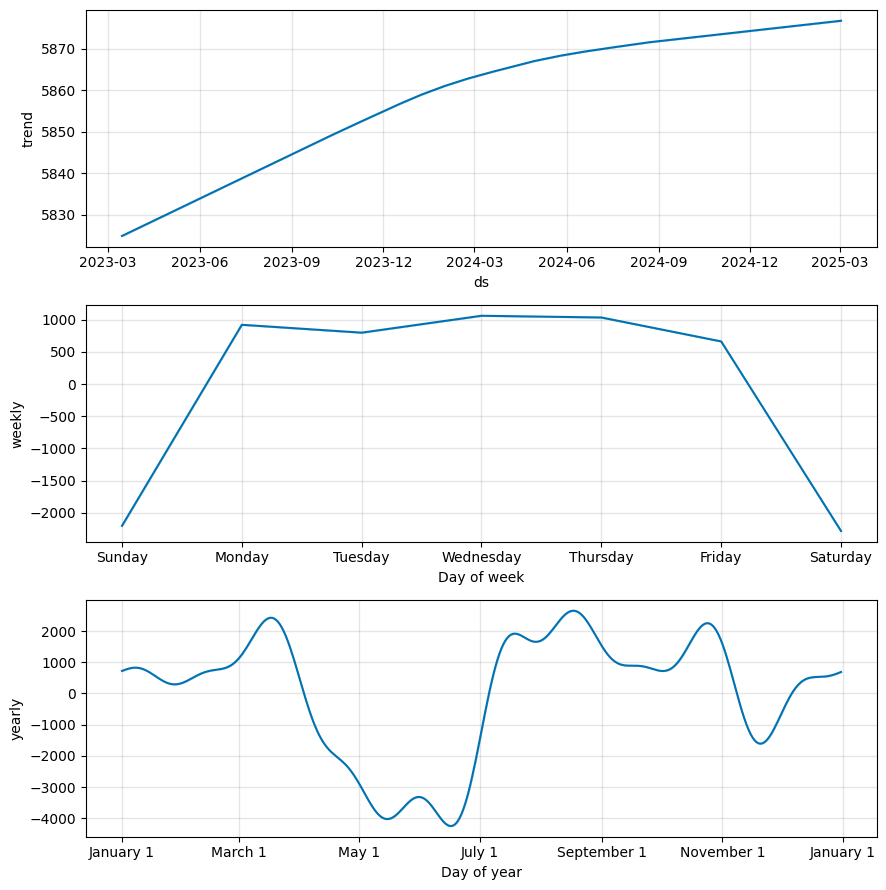

In [56]:
fig2 = model.plot_components(forecast)

In [57]:
date_rng = pd.date_range(start='2023-01-01', end='2023-3-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])

In [58]:
np.random.seed(42)
noise = np.random.randint(0, 15, size=(len(df)))

In [59]:
weekday_effect = df['date'].dt.dayofweek.apply(lambda x: 25 if x >= 5 else 0)

In [60]:
time_trend = np.arange(len(df)) * 0.1

In [61]:
df['patients'] = 80 + weekday_effect + time_trend + noise

In [62]:
df.set_index('date', inplace=True)

df.head()

,patients
date,
2023-01-01,111.0
2023-01-02,83.1
2023-01-03,92.2
2023-01-04,94.3
2023-01-05,90.4


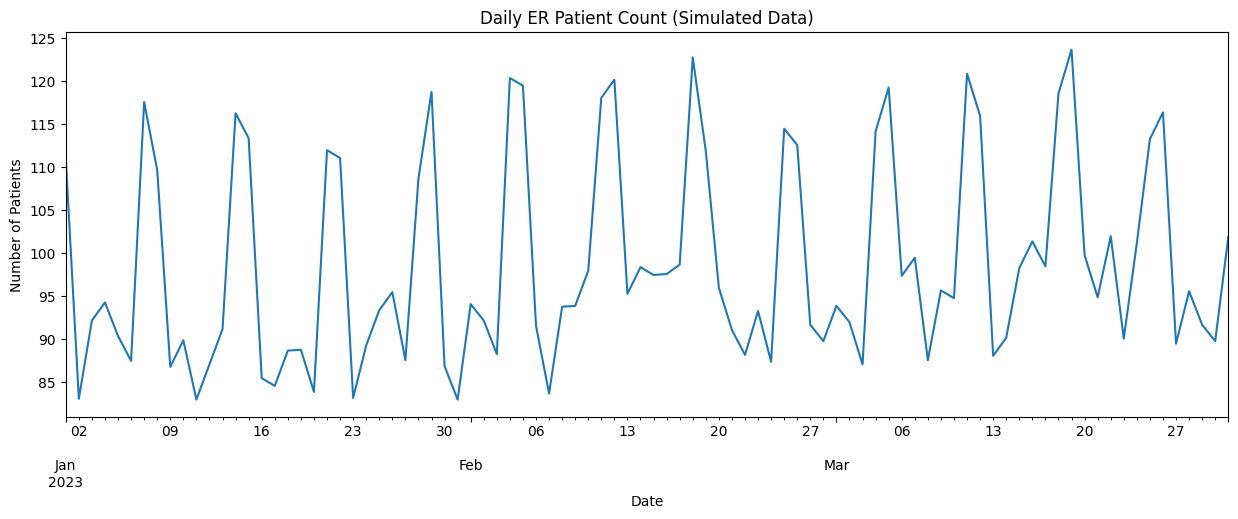

In [63]:
df['patients'].plot(figsize=(15, 5), title='Daily ER Patient Count (Simulated Data)')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.show()

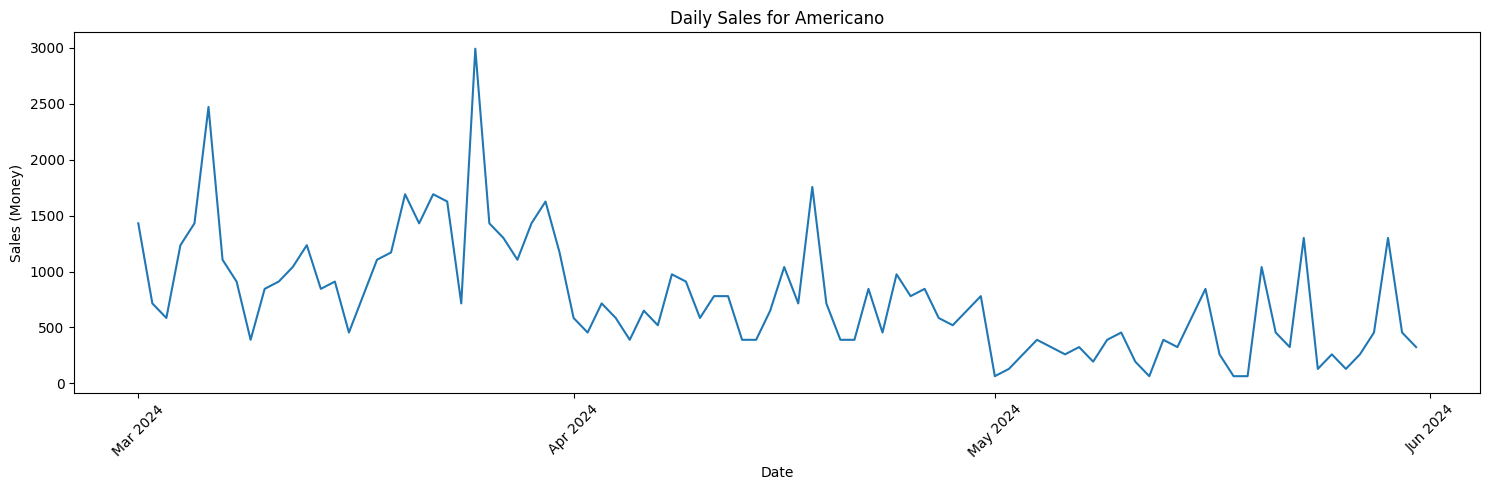

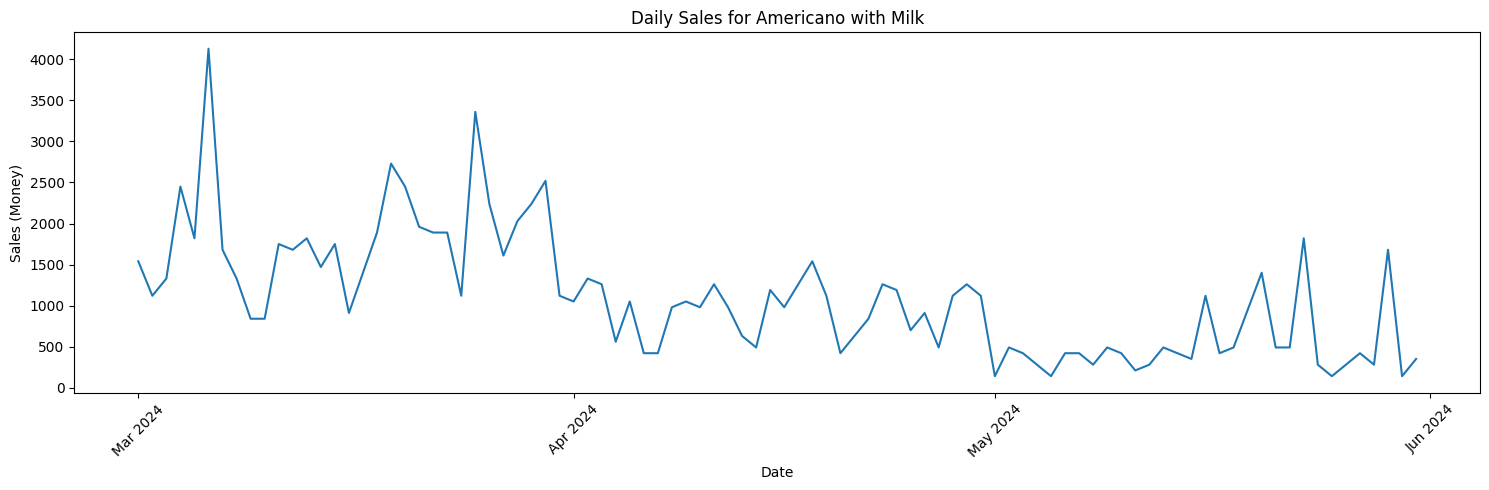

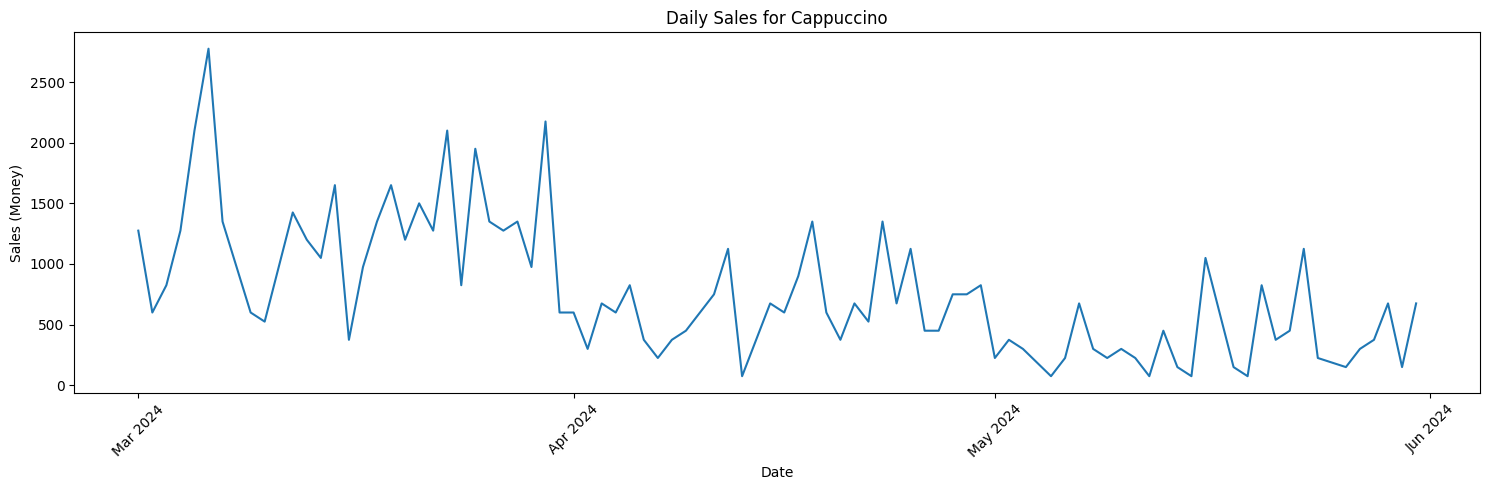

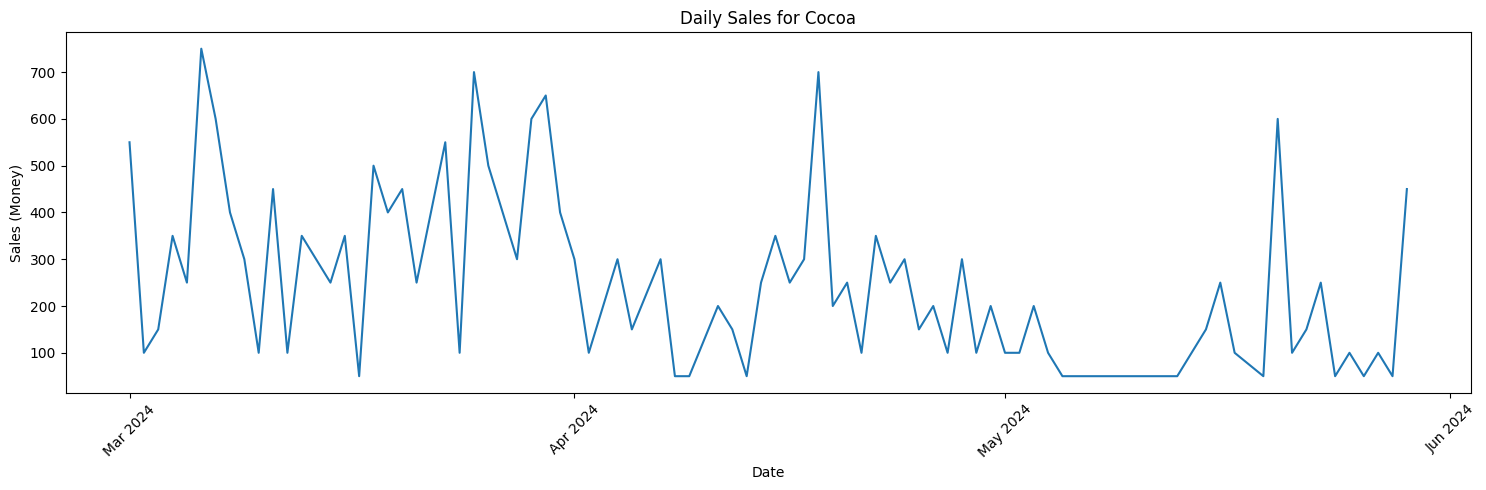

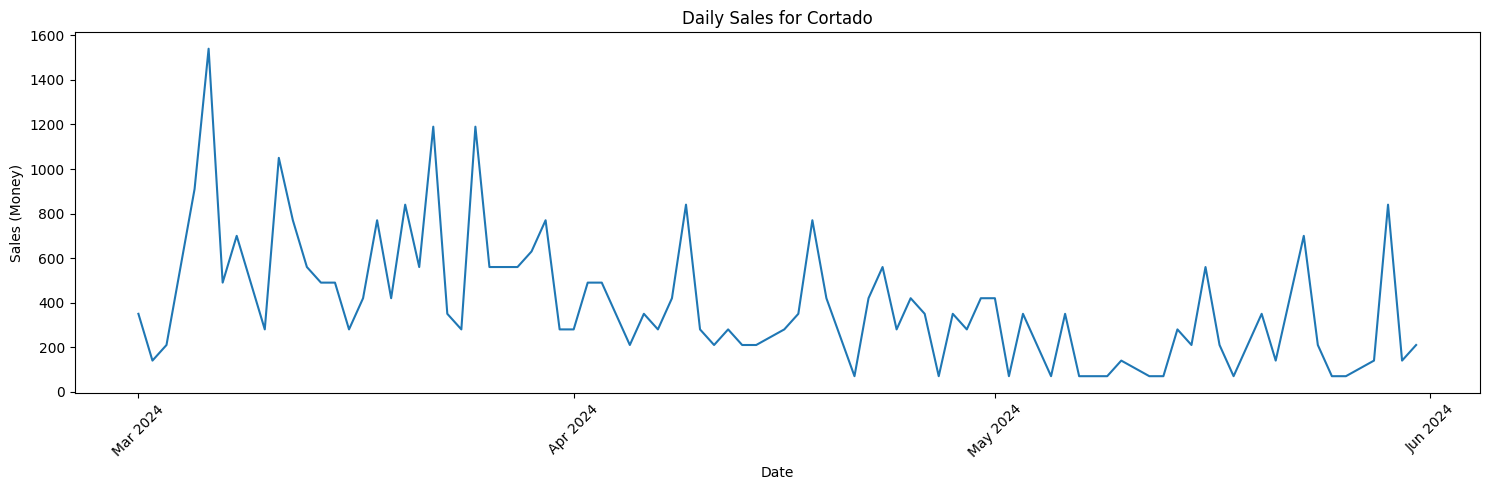

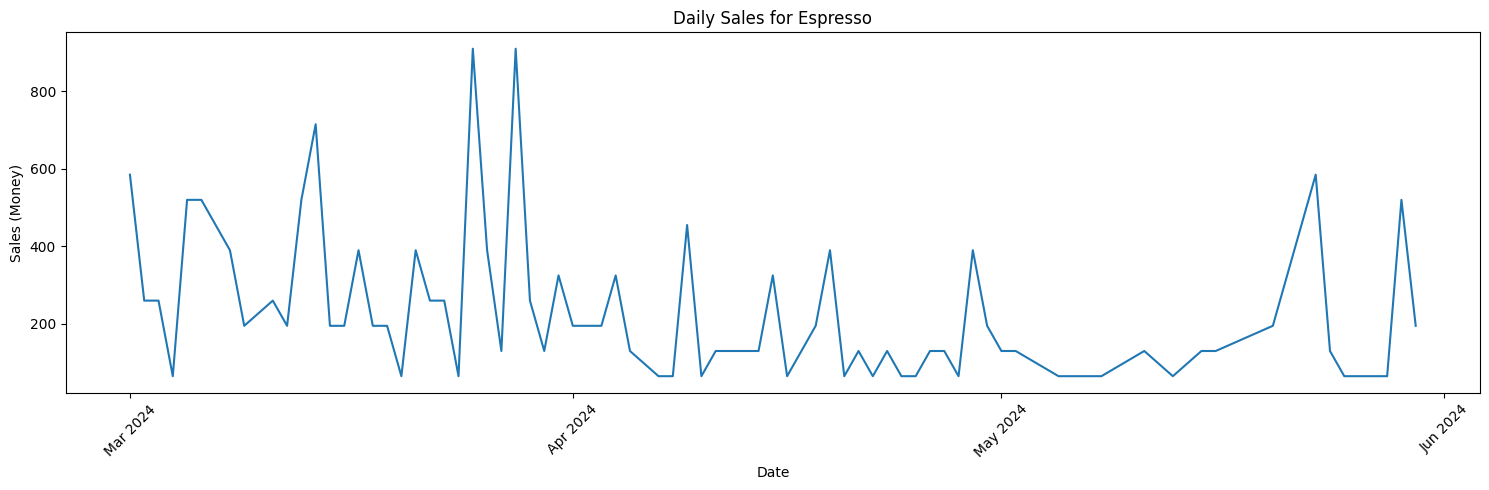

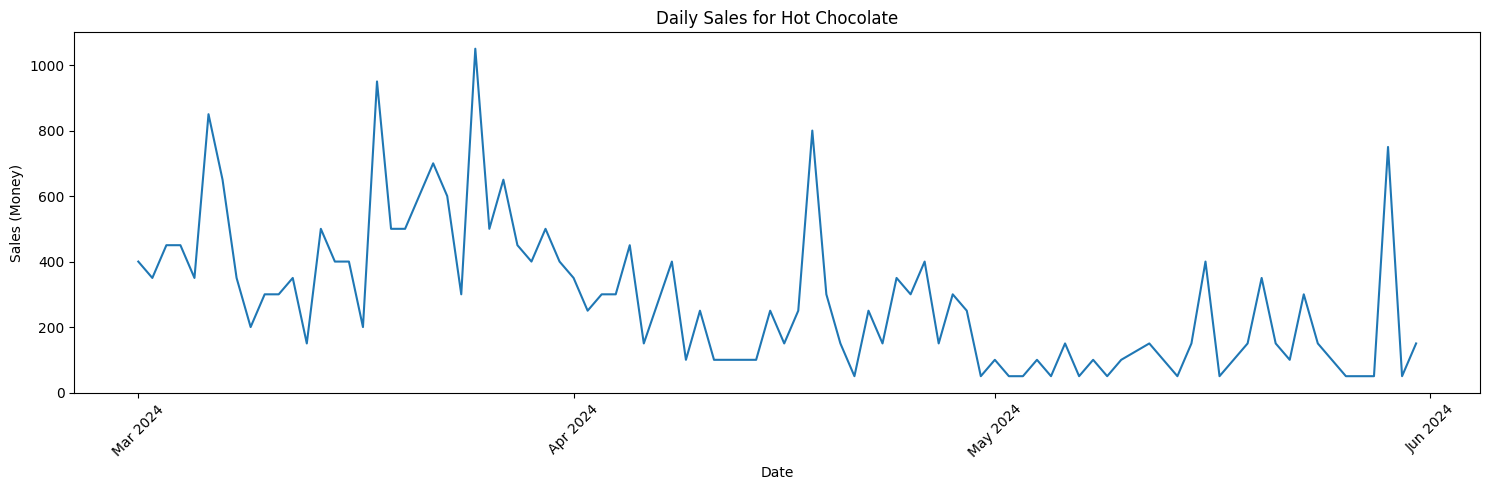

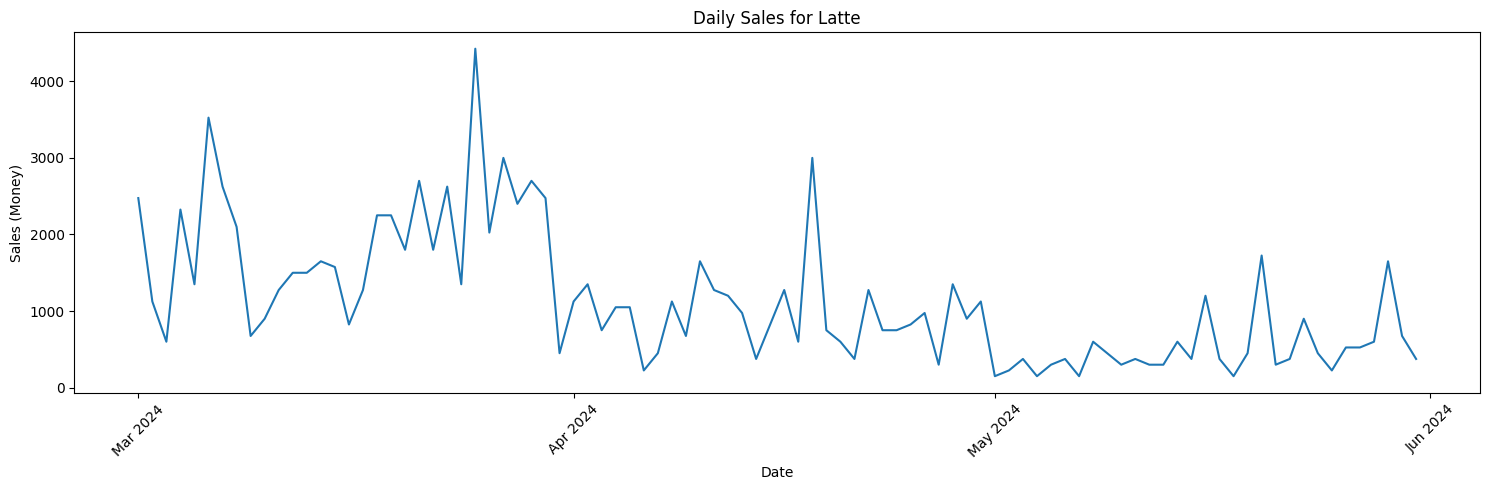

In [18]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2024-05-31'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

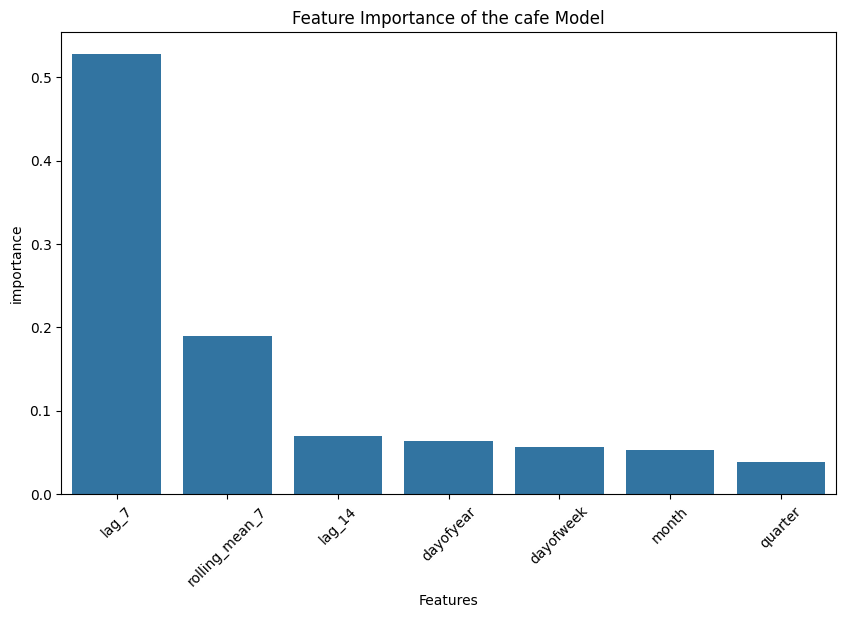

In [64]:
plot_feature_importance(xgb_model, FEATURES, 'cafe')